In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [2]:
!pip install preprocessing --upgrade
!pip install nltk --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [3]:
import warnings
warnings.simplefilter("ignore", ResourceWarning)

## Let's load the training data

In [4]:
summary_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
prompt_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')

## Check dataframe description

In [5]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


In [6]:
prompt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


## Primary key to combine dataframe on

In [7]:
prompt_df['prompt_id'].unique()

array(['39c16e', '3b9047', '814d6b', 'ebad26'], dtype=object)

In [8]:
summary_df['prompt_id'].unique()

array(['814d6b', 'ebad26', '3b9047', '39c16e'], dtype=object)

## Merge dataframe based on primary key into one

In [9]:
train_df = summary_df.merge(right=prompt_df,how='inner', on='prompt_id')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 503.8+ KB


### Let's perform a little exploratory analysis on the data to see what samples looks like

In [11]:
print('''Question: %s \n 
Title: %s \n
Text: %s'''%(train_df.iloc[1]['prompt_question'],train_df.iloc[1]['prompt_title'],train_df.iloc[1]['prompt_text']))

Question: Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. 
 
Title: The Third Wave 

Text: Background 
The Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline,

### Let's check what the student summary looks like

In [12]:
from pprint import pformat
print(pformat('''Question: %s
Summary: %s
Content Score: %s
Wording Score: %s'''%(train_df.iloc[0]['prompt_question'],train_df.iloc[0]['text'], train_df.iloc[0]['content'],
                           train_df.iloc[0]['wording'])))

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended.\n'
 'Summary: The third wave was an experimentto see how people reacted to a new '
 'one leader government. It gained popularity as people wanted to try new '
 'things. The students follow anything that is said and start turning on '
 'eachother to gain higher power. They had to stop the experement as too many '
 'people got to radical with it blindly following there leader\n'
 'Content Score: 0.205682506482641\n'
 'Wording Score: 0.380537638762288')


## Let's build a helper function that displays N text in a pretty format

In [13]:
def display_text(s=1,n=10,df=train_df):
    """
    This function takes n as input and displays n section of text
    """
    for i in range(s,n):
        p_sum = pformat('''Question: %s \nSummary: %s \nContent Score: %s \nWording Score: %s'''%(df.iloc[i]['prompt_question'],df.iloc[i]['text'], df.iloc[i]['content'],
                           df.iloc[i]['wording']))
        print(p_sum,end='\n\n')

In [14]:
display_text(s=200,n=220,df=train_df)

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended. \n'
 'Summary: The Third Wave developed over such a short period of time. Jones '
 'emphasized many simple rules and made sure the students did it right. '
 'Students also had to salute each other in a specific way that the teacher '
 'had made. On the fourth day, Jones claimed that things started getting out '
 'of control because the students became increasingly involved in the project, '
 'so their discipline and loyalty to the project was overly outstanding. So '
 'Jones decided to terminate the movement and lied to the students by '
 'announcing that the Third Wave was a part of a nationwide movement.  \n'
 'Content Score: 1.46743085810556 \n'
 'Wording Score: 1.84017156306968')

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended. \n'
 'Summary: It happened so fastly because the orig nail kid

#### Combine the Title, Question, Context and Summary text into one large block of text

In [15]:
sample = 'Title:\n'+train_df.iloc[0]['prompt_title']+'\nQuestion:\n'+train_df.iloc[0]['prompt_question']+'\nText:\n'+train_df.iloc[0]['prompt_text']+'\nAnswer:\n'+train_df.iloc[0]['text']

In [16]:
print(sample)

Title:
The Third Wave
Question:
Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
Text:
Background 
The Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline, stre

In [17]:
train_df['full_text'] = train_df.apply(lambda x: 'Title:\n'+x['prompt_title']+
               '\nQuestion:\n'+x['prompt_question']+
               '\nText:\n'+x['prompt_text']+
               '\nAnswer:\n'+x['text'],axis=1)

### Make a copy of the dataframe

In [18]:
df = train_df[['student_id','full_text','content','wording']].copy()

### Let's perform text preprocessing on our df full_text column

In [19]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Remove Stopwords

In [21]:
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer #,PorterStemmer, WordNetLemmatizer

In [22]:
def clean_text(text):
    stops = stopwords.words('english')
    processed_text = []
    for word in text.split():
        if word not in stops:
            processed_text.append(word)
    return ' '.join(processed_text)

### Convert words to stem

In [23]:
def stem_word(text):
    stem = LancasterStemmer()
    stemmed_data = []
    for word in text.split():
        stemmed_data.append(stem.stem(word.lower()))
    return ' '.join(stemmed_data)

### Create Bag of Words for data

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

### Input all libraries

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
def preprocess_data(summary_df,prompt_df,ngram_range=(1,1)):
    train_df = summary_df.merge(right=prompt_df,how='inner', on='prompt_id')
    train_df['full_text'] = train_df.apply(lambda x: 'Title:\n'+x['prompt_title']+
                   '\nQuestion:\n'+x['prompt_question']+
                   '\nText:\n'+x['prompt_text']+
                   '\nAnswer:\n'+x['text'],axis=1)
    train_df['full_text'] = train_df['full_text'].apply(clean_text)
    train_df['full_text'] = train_df['full_text'].apply(stem_word)
    train_df['length_of_summary'] = train_df['text'].apply(lambda x: len(x))
    train_df['summary_text'] = train_df.apply(lambda x: 'Question:\n'+x['prompt_question']+'\nAnswer:\n'+x['text'],axis=1)
    train_df['summary_text'] = train_df['summary_text'].apply(clean_text)
    train_df['summary_text'] = train_df['summary_text'].apply(stem_word)
    df = train_df[['student_id','full_text','summary_text','length_of_summary','content','wording']].copy()
    global transformer, vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    transformer = TfidfTransformer()
    transformed_df = transformer.fit_transform(vectorizer.fit_transform(df['full_text']))
    summary_transformed_df = transformer.transform(vectorizer.transform(df['summary_text']))
    scaler = StandardScaler(with_mean=True, with_std=True,)
    X_sample_scaled = scaler.fit_transform(transformed_df.toarray())
    X_summary_scaled = scaler.fit_transform(summary_transformed_df.toarray())
    pca = PCA(n_components=2207)
    pca_bag = pca.fit_transform(X_sample_scaled)
    summary_bag = pca.transform(X_summary_scaled)
    stacked_bag = np.hstack((pca_bag,summary_bag,df[['length_of_summary','content','wording']].values))
    student_ids = df['student_id'].values
    return stacked_bag, student_ids

In [27]:
bag_of_words, ids = preprocess_data(summary_df,prompt_df,ngram_range=(1,1))

In [28]:
bag_of_words.shape

(7165, 4417)

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)

In [30]:
def get_plot(d_lower,d_higher,cumsum):
    fig, axis = plt.subplots()
    axis.step(range(len(cumsum)),cumsum, where='mid', c='b', label='Explained Ration')
    axis.vlines(d_higher, 0, cumsum[d_higher], colors='orange', linestyles='--',label=f'{d_higher} components')
    axis.vlines(d_lower, 0, cumsum[d_lower],colors='red', linestyles='--', label=f'{d_lower} components')
    axis.hlines(cumsum[d_higher], -200, d_higher, colors='orange', linestyles='--', label=f'{cumsum[d_higher]:.2f} cumsum')
    axis.hlines(cumsum[d_lower], -200, d_lower,colors='red', linestyles='--', label=f'{cumsum[d_lower]:.2f} cumsum')
    axis.set_xlim([-200, 5000])
    axis.set_xlabel('Principal Components Index')
    axis.set_ylabel('Explained Variance Ratio')
    axis.grid(True)
    plt.legend(loc='best')
    plt.show()

In [31]:
# get_plot(d_lower=d_95,d_higher=d_99,cumsum=cumsum)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(bag_of_words[:,:-2] ,bag_of_words[:,-2:],test_size=0.1,shuffle=True,random_state=11)

In [33]:
from warnings import filterwarnings
filterwarnings(action='always')

In [34]:
# import tensorflow_decision_forests as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM, Input
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [35]:
f_shape = X_train.shape[1]
batch_size = 64

In [36]:
def expand_dims(features, labels):
    features = tf.expand_dims(features, axis=0)
    features = tf.cast(features, tf.float64, name='input_features')
    labels = tf.cast(labels, tf.float64, name='labels')
    return {'input_features':features}, labels

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset = dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
dataset = dataset.cache()
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(X_train.shape[0])
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
dataset.element_spec

({'input_features': TensorSpec(shape=(64, 1, 4415), dtype=tf.float64, name=None)},
 TensorSpec(shape=(64, 2), dtype=tf.float64, name=None))

In [39]:
def build_model():
    model = Sequential([
        Input(shape=(None,f_shape),batch_size=batch_size,name='input_features',dtype=tf.float32),
        tf.keras.layers.LSTM(128,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        Dense(64,activation='relu'),
        Dense(16, activation='relu'),
        Dense(2, activation='relu')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 loss=tf.keras.losses.Huber(), metrics=['mse'])
    return model

In [40]:
model = build_model()

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 128)                 2326528   
                                                                 
 dropout (Dropout)           (64, 128)                 0         
                                                                 
 dense (Dense)               (64, 64)                  8256      
                                                                 
 dense_1 (Dense)             (64, 16)                  1040      
                                                                 
 dense_2 (Dense)             (64, 2)                   34        
                                                                 
Total params: 2,335,858
Trainable params: 2,335,858
Non-trainable params: 0
_________________________________________________________________


In [42]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 2e-8 * 10**(epoch / 10))

In [43]:
history = model.fit(dataset,batch_size=batch_size,epochs=100,callbacks=[lr_schedule,early_stopping])

Epoch 1/100
100/100 [==============================] - 3s 15ms/step - loss: 3.4418 - mse: 26.4280 - lr: 2.0000e-08
Epoch 2/100
100/100 [==============================] - 2s 15ms/step - loss: 3.4101 - mse: 26.2648 - lr: 2.5179e-08
Epoch 3/100
100/100 [==============================] - 2s 15ms/step - loss: 3.4051 - mse: 25.9916 - lr: 3.1698e-08
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 3.3958 - mse: 25.4629 - lr: 3.9905e-08
Epoch 5/100
100/100 [==============================] - 2s 15ms/step - loss: 3.4167 - mse: 26.1333 - lr: 5.0238e-08
Epoch 6/100
100/100 [==============================] - 2s 15ms/step - loss: 3.4036 - mse: 25.8173 - lr: 6.3246e-08
Epoch 7/100
100/100 [==============================] - 2s 15ms/step - loss: 3.3887 - mse: 25.6235 - lr: 7.9621e-08
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 3.4244 - mse: 26.6957 - lr: 1.0024e-07
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 3.40

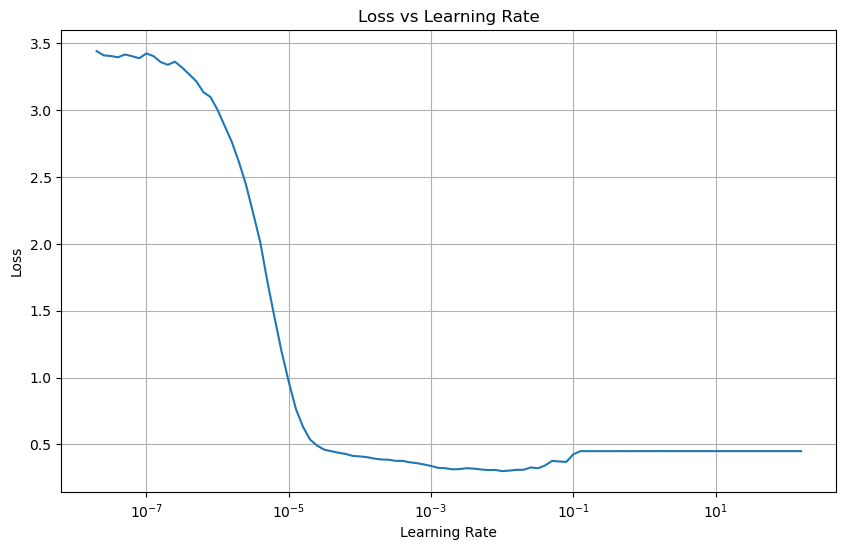

In [44]:
import matplotlib.pyplot as plt

# Extract learning rates and losses from the training history
lrs = history.history['lr']
losses = history.history['loss']

plt.figure(figsize=(10, 6))
plt.semilogx(lrs, losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.grid(True)
plt.show()


In [45]:
def build_model():
    model = Sequential([
        Input(shape=(None,f_shape),batch_size=batch_size,name='input_features',dtype=tf.float32),
        tf.keras.layers.LSTM(128,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        Dense(64,activation='relu'),
        Dense(16, activation='relu'),
        Dense(2, activation='relu')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=tf.keras.losses.Huber(), metrics=['mse'])
    return model

In [46]:
model = build_model()

In [47]:
# Assuming your original dataset has 1000 examples
dataset_size = X_train.shape[0]
val_size = int(dataset_size * 0.05)  # 5% for validation
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [48]:
history = model.fit(train_dataset,batch_size=batch_size,validation_data=val_dataset,epochs=100,callbacks=[early_stopping])

Epoch 1/100
100/100 [==============================] - 3s 14ms/step - loss: 0.4540 - mse: 1.1052
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4502 - mse: 1.0856
Epoch 3/100
100/100 [==============================] - 1s 13ms/step - loss: 0.4500 - mse: 1.0845
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4500 - mse: 1.0845
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4505 - mse: 1.0885
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4500 - mse: 1.0845
Epoch 7/100
100/100 [==============================] - 1s 13ms/step - loss: 0.4500 - mse: 1.0845
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4500 - mse: 1.0845
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4500 - mse: 1.0845
Epoch 10/100
100/100 [==============================] - 2s 15ms/step - loss: 0.4500 - mse: 1.0845
Epoch 11/100
100/100 [=======

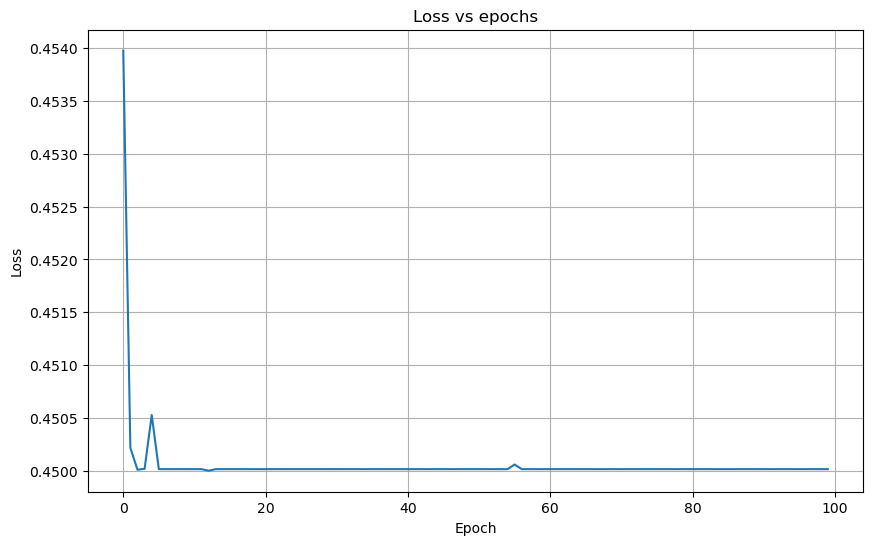

In [49]:
import matplotlib.pyplot as plt

# Extract learning rates and losses from the training history
epochs = range(len(history.history['loss']))
losses = history.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.grid(True)
plt.show()

In [50]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=1, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(X_test.shape[0])
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [51]:
val_dataset.element_spec

({'input_features': TensorSpec(shape=(1, 1, 4415), dtype=tf.float64, name=None)},
 TensorSpec(shape=(1, 2), dtype=tf.float64, name=None))

In [52]:
preds = model.predict(val_dataset)

717/717 [==============================] - 2s 2ms/step


In [53]:
preds.shape, y_test.shape

((717, 2), (717, 2))

In [54]:
def mcrmse(y_true, y_pred):
    return np.mean(np.sqrt(np.mean((y_true - y_pred)**2, axis=0)))

In [55]:
mcrmse(y_test,preds)

1.0308988352180275

In [56]:
train_dataset.element_spec

({'input_features': TensorSpec(shape=(64, 1, 4415), dtype=tf.float64, name=None)},
 TensorSpec(shape=(64, 2), dtype=tf.float64, name=None))